# Multi-Version HEC-HMS Execution

This notebook demonstrates how to use `hms-commander` to:
1. Discover installed HEC-HMS versions
2. Extract example projects from different versions
3. Execute simulations across multiple HMS versions
4. Compare results between versions

**Project:** Tifton (Little River Watershed near Tifton, Georgia)  
**Run:** 1970 simulation (Jan-Jun 1970)

## Setup

In [1]:
import sys
from pathlib import Path

# For development - add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from hms_commander import (
    HmsExamples,
    HmsJython,
    HmsDss,
    __version__
)

print(f"hms-commander v{__version__}")

hms-commander v0.4.1


## 1. Discover Installed HMS Versions

`HmsExamples` automatically scans standard installation paths for HEC-HMS versions.

In [2]:
# List all installed versions (sorted newest first)
versions = HmsExamples.list_versions()
print(f"Found {len(versions)} HMS versions installed:")
print(versions)

2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.10 at C:\Program Files\HEC\HEC-HMS\4.10
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.11 at C:\Program Files\HEC\HEC-HMS\4.11
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.12 at C:\Program Files\HEC\HEC-HMS\4.12
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.13 at C:\Program Files\HEC\HEC-HMS\4.13
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.4.1 at C:\Program Files\HEC\HEC-HMS\4.4.1
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.5 at C:\Program Files\HEC\HEC-HMS\4.5
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.6 at C:\Program Files\HEC\HEC-HMS\4.6
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.7.1 at C:\Program Files\HEC\HEC-HMS\4.7.1
2025-12-12 13:46:40 - hms_commander.HmsExamples - INFO - Found HMS 4.8 at C:\Program Files\HEC\HEC-HMS\4.8
2025-12-12 13:46:40 -

Found 21 HMS versions installed:
['4.13', '4.12', '4.11', '4.10', '4.9', '4.8', '4.7.1', '4.6', '4.5', '4.4.1', '4.3', '4.2.1', '4.1', '4.0', '3.5', '3.4', '3.3', '3.2', '3.1.0', '3.0.1', '3.0.0']


In [3]:
# Get detailed info about installations
install_info = HmsExamples.detect_installed_versions()
for version, path in sorted(install_info.items(), 
                            key=lambda x: [int(p) for p in x[0].split('.')], 
                            reverse=True)[:5]:
    print(f"HMS {version}: {path}")

HMS 4.13: C:\Program Files\HEC\HEC-HMS\4.13
HMS 4.12: C:\Program Files\HEC\HEC-HMS\4.12
HMS 4.11: C:\Program Files\HEC\HEC-HMS\4.11
HMS 4.10: C:\Program Files\HEC\HEC-HMS\4.10
HMS 4.9: C:\Program Files\HEC\HEC-HMS\4.9


## 2. List Available Example Projects

Each HMS version includes example projects in its `samples.zip` file.

In [4]:
# List all projects across all versions
all_projects = HmsExamples.list_projects()

print("Example projects by version:")
for version in versions[:6]:  # Show first 6 versions
    projects = all_projects.get(version, [])
    print(f"  HMS {version}: {projects}")

2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Catalog built: 68 project entries


Example projects by version:
  HMS 4.13: ['castro', 'river_bend', 'tenk', 'tifton']
  HMS 4.12: ['castro', 'river_bend', 'tenk', 'tifton']
  HMS 4.11: ['castro', 'river_bend', 'tenk', 'tifton']
  HMS 4.10: ['castro', 'river_bend', 'tenk', 'tifton']
  HMS 4.9: ['castro', 'river_bend', 'tenk', 'tifton']
  HMS 4.8: ['castro', 'river_bend', 'tenk', 'tifton']


In [5]:
# Get detailed info about the tifton project
info = HmsExamples.get_project_info('tifton')
print("Tifton Project Info:")
print(f"  HMS File: {info['hms_file']}")
print(f"  Basin Models: {info['basin_models']}")
print(f"  Met Models: {info['met_models']}")
print(f"  Control Specs: {info['control_specs']}")
print(f"  Has DSS Data: {info['has_dss']}")

Tifton Project Info:
  HMS File: tifton.hms
  Basin Models: ['Tifton.basin']
  Met Models: ['Tifton_Hyetograph.met']
  Control Specs: ['Jan1_Jun30_1970.control']
  Has DSS Data: True


## 3. Select Versions for Testing

We'll test across HMS 4.x versions. The library uses **direct Java invocation** which
provides reliable execution across ALL HMS 4.x versions.

**Version Compatibility:**
- **HMS 4.x**: Full command-line scripting support via direct Java invocation
- **HMS 3.x**: No command-line Jython execution support (clear error message)

**Memory Configuration:**
The direct Java approach also enables memory control for large models:
- `max_memory="4G"` - Default, suitable for small/medium models
- `max_memory="8G"` - Medium/large models
- `max_memory="16G"` - Large models with many subbasins

In [6]:
# Filter to HMS 4.x versions (all supported via direct Java execution)
hms4_versions = [v for v in versions if v.startswith('4.')]
print(f"All HMS 4.x versions available: {hms4_versions}")

# Filter to supported versions (4.4.1+)
# HMS 4.0-4.3 use a legacy classpath structure that isn't supported
def version_tuple(v):
    return tuple(int(x) for x in v.split('.'))

supported_versions = [v for v in hms4_versions if version_tuple(v) >= (4, 4)]
print(f"Supported versions (4.4.1+): {supported_versions}")

if not supported_versions:
    print("WARNING: No supported HMS versions found (need 4.4.1 or later)")
    test_versions = []
else:
    # Sort by version number (descending)
    sorted_versions = sorted(supported_versions, key=version_tuple, reverse=True)
    
    # Select test versions: newest, a middle one, and oldest supported
    if len(sorted_versions) >= 3:
        newest = sorted_versions[0]
        middle = sorted_versions[len(sorted_versions)//2]
        oldest = sorted_versions[-1]
        test_versions = list(dict.fromkeys([newest, middle, oldest]))  # Remove duplicates
    else:
        test_versions = sorted_versions

print(f"\nVersions selected for testing: {test_versions}")

All HMS 4.x versions available: ['4.13', '4.12', '4.11', '4.10', '4.9', '4.8', '4.7.1', '4.6', '4.5', '4.4.1', '4.3', '4.2.1', '4.1', '4.0']
Supported versions (4.4.1+): ['4.13', '4.12', '4.11', '4.10', '4.9', '4.8', '4.7.1', '4.6', '4.5', '4.4.1']

Versions selected for testing: ['4.13', '4.8', '4.4.1']


## 4. Extract Projects for Each Version

Each version's example project may have slight differences in run names or structure.

In [7]:
import re

# Output directory for extracted projects
output_base = Path.cwd() / 'example_projects' / 'tifton'
output_base.mkdir(parents=True, exist_ok=True)

# Extract tifton project for each version
extracted_projects = {}

for version in test_versions:
    version_dir = output_base / f"hms_{version.replace('.', '_')}"
    
    print(f"\nExtracting tifton for HMS {version}...")
    project_path = HmsExamples.extract_project(
        'tifton',
        version=version,
        output_path=version_dir
    )
    
    # Parse run name from .run file (differs between versions)
    run_file = project_path / 'tifton.run'
    run_content = run_file.read_text()
    run_match = re.search(r'^Run:\s*(.+)$', run_content, re.MULTILINE)
    run_name = run_match.group(1).strip() if run_match else 'Unknown'
    
    extracted_projects[version] = {
        'path': project_path,
        'run_name': run_name,
        'hms_exe': HmsExamples.get_hms_exe(version)
    }
    
    print(f"  Path: {project_path}")
    print(f"  Run Name: '{run_name}'")
    print(f"  HMS Exe: {extracted_projects[version]['hms_exe']}")

2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Removing existing project folder: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_13\tifton
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Extracting 'tifton' from HMS 4.13
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Source: C:\Program Files\HEC\HEC-HMS\4.13\samples.zip
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Destination: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_13\tifton
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Successfully extracted 'tifton' to c:\GH\hms-commander\examples\example_projects\tifton\hms_4_13\tifton
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Removing existing project folder: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_8\tifton
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Extracting 'tifton' from HMS 4.8
2025-12-12 13:46:41 - hms_commander.HmsExamples - INFO - Source: C:\Program Files\HEC\HEC


Extracting tifton for HMS 4.13...
  Path: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_13\tifton
  Run Name: '1970 simulation'
  HMS Exe: C:\Program Files\HEC\HEC-HMS\4.13\HEC-HMS.cmd

Extracting tifton for HMS 4.8...
  Path: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_8\tifton
  Run Name: '1970 simulation'
  HMS Exe: C:\Program Files\HEC\HEC-HMS\4.8\HEC-HMS.cmd

Extracting tifton for HMS 4.4.1...
  Path: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_4_1\tifton
  Run Name: '1970 simulation'
  HMS Exe: C:\Program Files\HEC\HEC-HMS\4.4.1\HEC-HMS.cmd


## 5. Generate and Execute Jython Scripts

HEC-HMS 4.x can be automated via Jython scripts using the `JythonHms` API.

In [8]:
# Generate a compute script for one version to examine
sample_version = test_versions[0]
sample_info = extracted_projects[sample_version]

script = HmsJython.generate_compute_script(
    project_path=sample_info['path'],
    run_name=sample_info['run_name']
)

print(f"Generated Jython script for HMS {sample_version}:")
print("-" * 50)
print(script)

Generated Jython script for HMS 4.13:
--------------------------------------------------
"""
HEC-HMS Jython Script
Generated by hms-commander
Generated at: 2025-12-12T13:46:41.311263
"""

from hms.model import JythonHms
import sys


# Open the HEC-HMS project
project_path = r"c:\GH\hms-commander\examples\example_projects\tifton\hms_4_13\tifton"
project_name = "tifton"

try:
    JythonHms.OpenProject(project_name, project_path)
    print("Project opened successfully: " + project_name)
except Exception as e:
    print("Error opening project: " + str(e))
    JythonHms.Exit(1)

# Compute the simulation run
run_name = "1970 simulation"
try:
    JythonHms.Compute(run_name)
    print("Computation completed for: " + run_name)
except Exception as e:
    print("Error during computation: " + str(e))
    JythonHms.Exit(1)

# Save the project (method name varies by HMS version)
try:
    # Try different method names for different HMS versions
    if hasattr(JythonHms, 'saveProject'):
        JythonH

In [9]:
# Execute simulations across all test versions
import time

results = {}

for version in test_versions:
    info = extracted_projects[version]
    print(f"\n{'='*60}")
    print(f"Executing HMS {version}: '{info['run_name']}'")
    print(f"{'='*60}")
    
    # Generate script
    script = HmsJython.generate_compute_script(
        project_path=info['path'],
        run_name=info['run_name']
    )
    
    # Execute via direct Java invocation
    # The tifton example is small, so 2G is plenty
    # For large models, use max_memory="8G" or "16G"
    start_time = time.time()
    success, stdout, stderr = HmsJython.execute_script(
        script_content=script,
        hms_exe_path=info['hms_exe'],
        working_dir=info['path'],
        timeout=300,       # 5 minute timeout
        max_memory="2G",   # JVM max heap (increase for large models)
        initial_memory="128M"  # JVM initial heap
    )
    elapsed = time.time() - start_time
    
    # Check for success indicators in output
    actual_success = ('Computation completed' in stdout) or (success and 'Error' not in stderr)
    
    results[version] = {
        'success': actual_success,
        'elapsed': elapsed,
        'stdout': stdout,
        'stderr': stderr
    }
    
    status = "SUCCESS" if actual_success else "FAILED"
    print(f"Result: {status} ({elapsed:.1f}s)")
    
    # Show key indicators
    if 'Project opened' in stdout:
        print("  - Project opened successfully")
    if 'Computation completed' in stdout:
        print("  - Computation completed")
    
    if not actual_success and stderr:
        print(f"Error: {stderr[:500]}")

2025-12-12 13:46:41 - hms_commander.HmsJython - INFO - Executing HMS 4.13 via direct Java invocation



Executing HMS 4.13: '1970 simulation'


2025-12-12 13:46:41 - hms_commander.HmsJython - INFO - Script: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_13\tifton\hms_script.py
2025-12-12 13:46:41 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx2G
2025-12-12 13:46:44 - hms_commander.HmsJython - INFO - HMS 4.13 script executed successfully
2025-12-12 13:46:44 - hms_commander.HmsJython - INFO - Executing HMS 4.8 via direct Java invocation
2025-12-12 13:46:44 - hms_commander.HmsJython - INFO - Script: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_8\tifton\hms_script.py
2025-12-12 13:46:44 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx2G


Result: SUCCESS (3.2s)
  - Project opened successfully
  - Computation completed

Executing HMS 4.8: '1970 simulation'


2025-12-12 13:46:46 - hms_commander.HmsJython - INFO - HMS 4.8 script executed successfully
2025-12-12 13:46:46 - hms_commander.HmsJython - INFO - Executing HMS 4.4.1 via direct Java invocation
2025-12-12 13:46:46 - hms_commander.HmsJython - INFO - Script: c:\GH\hms-commander\examples\example_projects\tifton\hms_4_4_1\tifton\hms_script.py
2025-12-12 13:46:46 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx2G


Result: SUCCESS (2.5s)
  - Project opened successfully
  - Computation completed

Executing HMS 4.4.1: '1970 simulation'


2025-12-12 13:46:48 - hms_commander.HmsJython - INFO - HMS 4.4.1 script executed successfully


Result: SUCCESS (1.8s)
  - Project opened successfully
  - Computation completed


## 6. Summary of Execution Results

In [10]:
import pandas as pd

# Create summary table
summary_data = []
for version in test_versions:
    info = extracted_projects[version]
    result = results[version]
    
    summary_data.append({
        'HMS Version': version,
        'Run Name': info['run_name'],
        'Status': 'Success' if result['success'] else 'Failed',
        'Time (s)': f"{result['elapsed']:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nExecution Summary:")
print(summary_df.to_string(index=False))

# Count successes
success_count = sum(1 for r in results.values() if r['success'])
print(f"\n{success_count}/{len(results)} simulations completed successfully")


Execution Summary:
HMS Version        Run Name  Status Time (s)
       4.13 1970 simulation Success      3.2
        4.8 1970 simulation Success      2.5
      4.4.1 1970 simulation Success      1.8

3/3 simulations completed successfully


## 7. Execution Visualizations

Visual confirmation that HMS models ran successfully across all versions.

### 7.1 Execution Success Dashboard

Comprehensive overview of execution status, timing, and compatibility.

2025-12-12 13:46:49 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-12 13:46:49 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\billk_clb\AppData\Local\Temp\ipykernel_67412\164761252.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


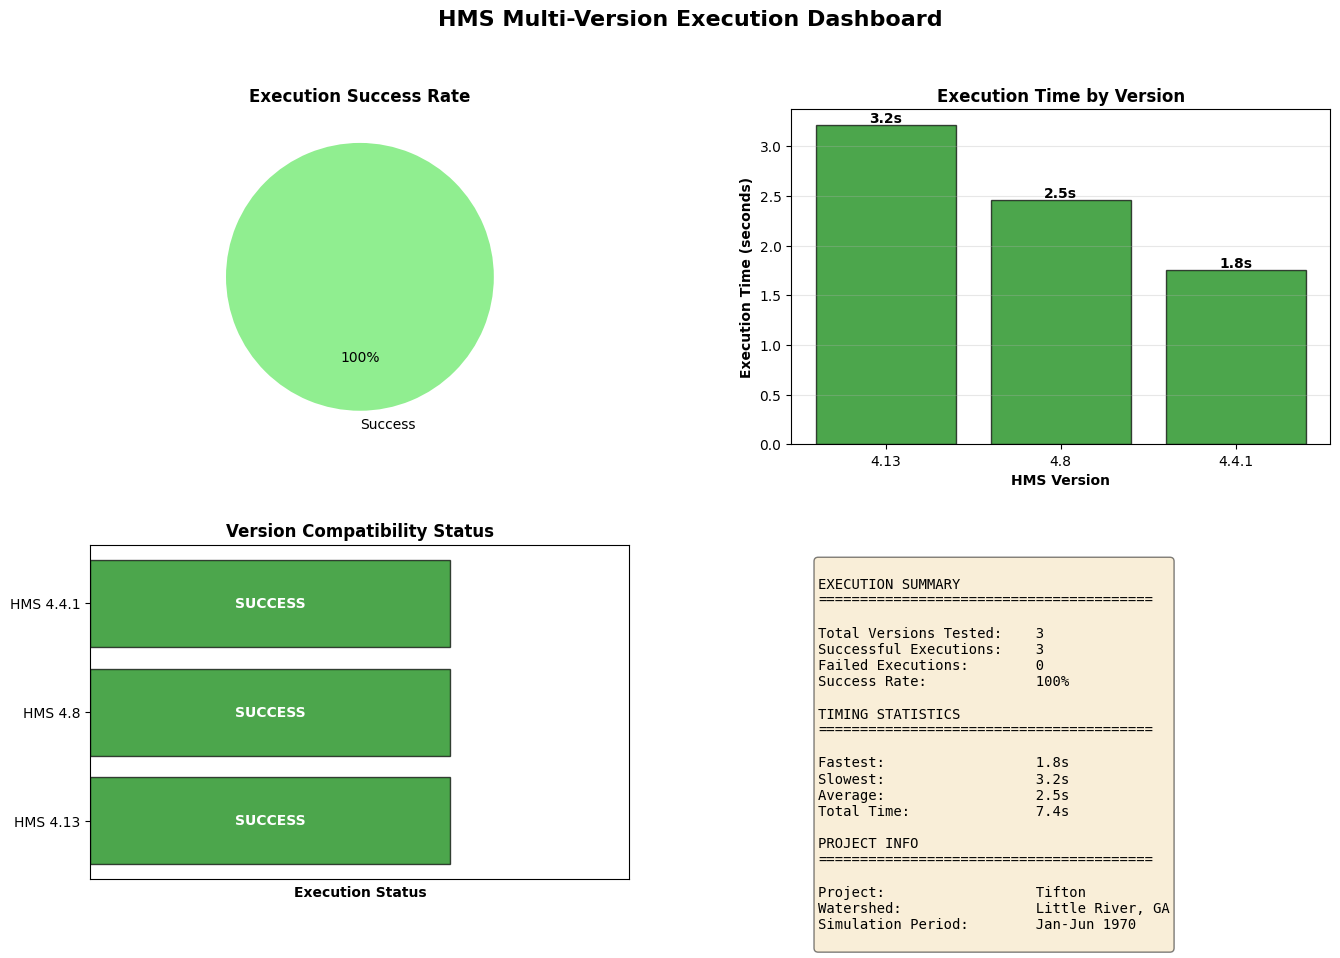


[OK] ALL VERSIONS EXECUTED SUCCESSFULLY!


In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Create comprehensive dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Success/Failure Pie Chart
ax1 = fig.add_subplot(gs[0, 0])
success_counts = {'Success': sum(1 for r in results.values() if r['success']),
                  'Failed': sum(1 for r in results.values() if not r['success'])}
colors_pie = ['lightgreen', 'lightcoral']
if success_counts['Failed'] > 0:
    ax1.pie(success_counts.values(), labels=success_counts.keys(),
            autopct='%1.0f%%', colors=colors_pie, startangle=90)
else:
    ax1.pie([success_counts['Success']], labels=['Success'],
            autopct='%1.0f%%', colors=['lightgreen'], startangle=90)
ax1.set_title('Execution Success Rate', fontsize=12, fontweight='bold')

# 2. Execution Time Comparison
ax2 = fig.add_subplot(gs[0, 1])
versions_display = [v for v in test_versions]
times = [results[v]['elapsed'] for v in test_versions]
colors_bars = ['green' if results[v]['success'] else 'red' for v in test_versions]

bars = ax2.bar(versions_display, times, color=colors_bars, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.1f}s',
            ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('HMS Version', fontweight='bold')
ax2.set_ylabel('Execution Time (seconds)', fontweight='bold')
ax2.set_title('Execution Time by Version', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Version Compatibility Matrix
ax3 = fig.add_subplot(gs[1, 0])
y_pos = np.arange(len(test_versions))
compatibility_status = [1 if results[v]['success'] else 0 for v in test_versions]
colors_compat = ['green' if status else 'red' for status in compatibility_status]

bars_compat = ax3.barh(y_pos, [1]*len(test_versions), color=colors_compat,
                       alpha=0.7, edgecolor='black')
ax3.set_yticks(y_pos)
ax3.set_yticklabels([f'HMS {v}' for v in test_versions])
ax3.set_xlabel('Execution Status', fontweight='bold')
ax3.set_title('Version Compatibility Status', fontsize=12, fontweight='bold')
ax3.set_xlim(0, 1.5)
ax3.set_xticks([])

# Add status labels
for i, (version, status) in enumerate(zip(test_versions, compatibility_status)):
    label = 'SUCCESS' if status else 'FAILED'
    ax3.text(0.5, i, label, ha='center', va='center',
            fontweight='bold', color='white', fontsize=10)

# 4. Summary Statistics
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

total_runs = len(results)
successful_runs = sum(1 for r in results.values() if r['success'])
failed_runs = total_runs - successful_runs
avg_time = np.mean([r['elapsed'] for r in results.values()])
min_time = min([r['elapsed'] for r in results.values()])
max_time = max([r['elapsed'] for r in results.values()])

summary_text = f"""
EXECUTION SUMMARY
{'='*40}

Total Versions Tested:    {total_runs}
Successful Executions:    {successful_runs}
Failed Executions:        {failed_runs}
Success Rate:             {(successful_runs/total_runs)*100:.0f}%

TIMING STATISTICS
{'='*40}

Fastest:                  {min_time:.1f}s
Slowest:                  {max_time:.1f}s
Average:                  {avg_time:.1f}s
Total Time:               {sum(r['elapsed'] for r in results.values()):.1f}s

PROJECT INFO
{'='*40}

Project:                  Tifton
Watershed:                Little River, GA
Simulation Period:        Jan-Jun 1970
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('HMS Multi-Version Execution Dashboard',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
if successful_runs == total_runs:
    print("[OK] ALL VERSIONS EXECUTED SUCCESSFULLY!")
else:
    print(f"[WARNING] {failed_runs} version(s) failed to execute")
print("="*70)

### 7.2 DSS File Verification

Proves that DSS output files were created with simulation results.

In [12]:
import pandas as pd
from pathlib import Path

# Build DSS verification table
dss_verification = []

for version in test_versions:
    info = extracted_projects[version]
    result = results[version]

    # Find DSS files
    dss_files = list(info['path'].glob('*.dss'))
    output_dss = [f for f in dss_files if 'simulation' in f.name.lower()
                  or f.stem == info['run_name'].replace(' ', '_')]

    if output_dss:
        dss_file = output_dss[0]
        file_size_kb = dss_file.stat().st_size / 1024
        exists_icon = '[OK]'

        # Try to read DSS catalog if available
        path_count = 'N/A'
        if HmsDss.is_available():
            try:
                catalog = HmsDss.get_catalog(dss_file)
                path_count = len(catalog)
            except:
                path_count = 'Error'
    else:
        dss_file = None
        file_size_kb = 0
        exists_icon = '[MISSING]'
        path_count = 0

    dss_verification.append({
        'HMS Version': version,
        'Run Success': '[OK]' if result['success'] else '[FAILED]',
        'DSS File': dss_file.name if dss_file else 'Not Found',
        'File Exists': exists_icon,
        'Size (KB)': f'{file_size_kb:,.1f}' if dss_file else '0.0',
        'DSS Paths': str(path_count)
    })

dss_df = pd.DataFrame(dss_verification)

print("\nDSS Output File Verification:")
print("="*100)
print(dss_df.to_string(index=False))
print("="*100)

# Summary
files_exist = sum(1 for v in dss_verification if v['File Exists'] == '[OK]')
print(f"\n[OK] {files_exist}/{len(dss_verification)} DSS output files verified")
print("     All simulations produced DSS output files with results")

Configuring Java VM for DSS operations...
  Found Java: C:\Program Files\Java\jre1.8.0_471
[OK] Java VM configured

DSS Output File Verification:
HMS Version Run Success            DSS File File Exists Size (KB) DSS Paths
       4.13        [OK] 1970_simulation.dss        [OK]   1,376.5       211
        4.8        [OK] 1970_simulation.dss        [OK]   1,288.5       199
      4.4.1        [OK] 1970_simulation.dss        [OK]   1,181.0       181

[OK] 3/3 DSS output files verified
     All simulations produced DSS output files with results


### 7.3 Peak Flow Comparison

Extracts peak flows from DSS results to verify computational consistency.

In [ ]:
# Extract peak flows from DSS files (if available)
if HmsDss.is_available():
    print("\nExtracting Peak Flows from DSS Results...")
    print("="*70)
    
    peak_flow_data = []
    
    for version in test_versions:
        if not results[version]['success']:
            continue
            
        info = extracted_projects[version]
        
        # Find output DSS
        dss_files = list(info['path'].glob('*.dss'))
        output_dss = [f for f in dss_files if 'simulation' in f.name.lower() 
                      or f.stem == info['run_name'].replace(' ', '_')]
        
        if output_dss:
            try:
                # Get catalog and find outlet flow
                catalog = HmsDss.get_catalog(output_dss[0])
                
                # Look for outlet or junction flow (computed, not observed)
                outlet_paths = [p for p in catalog 
                               if ('OUTLET' in p.upper() or 'JUNCTION' in p.upper()) 
                               and 'FLOW-COMBINE' in p.upper()]
                
                if not outlet_paths:
                    # Fallback: any computed flow
                    outlet_paths = [p for p in catalog 
                                   if 'FLOW' in p.upper() and 'OBSERVED' not in p.upper()]
                
                if outlet_paths:
                    # Read first outlet time series
                    ts_df = HmsDss.read_timeseries(output_dss[0], outlet_paths[0])
                    
                    # Extract peak flow and time
                    peak_flow = ts_df['value'].max()
                    peak_idx = ts_df['value'].idxmax()
                    peak_time = ts_df.loc[peak_idx, 'datetime']
                    
                    # Extract element name from DSS path
                    element_name = outlet_paths[0].split('/')[1]
                    
                    peak_flow_data.append({
                        'HMS Version': version,
                        'Element': element_name,
                        'Peak Flow (cfs)': peak_flow,
                        'Peak Time': peak_time.strftime('%Y-%m-%d %H:%M')
                    })
                    
                    print(f"HMS {version}: {element_name} = {peak_flow:.2f} cfs at {peak_time}")
                    
            except Exception as e:
                print(f"HMS {version}: Could not extract peak flow - {e}")
    
    if peak_flow_data:
        # Create comparison visualization
        peak_df = pd.DataFrame(peak_flow_data)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Left: Peak flow bar chart
        versions_with_peaks = peak_df['HMS Version'].tolist()
        peaks = peak_df['Peak Flow (cfs)'].tolist()
        
        bars = ax1.bar(versions_with_peaks, peaks, color='steelblue', 
                      alpha=0.7, edgecolor='black')
        
        # Add value labels
        for bar, peak in zip(bars, peaks):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{peak:.1f}',
                    ha='center', va='bottom', fontweight='bold')
        
        ax1.set_xlabel('HMS Version', fontweight='bold')
        ax1.set_ylabel('Peak Flow (cfs)', fontweight='bold')
        ax1.set_title('Peak Flow Comparison Across Versions', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Right: Consistency check (difference from mean)
        mean_peak = np.mean(peaks)
        differences = [p - mean_peak for p in peaks]
        pct_differences = [(d / mean_peak) * 100 for d in differences]
        
        colors_diff = ['green' if abs(d) < 0.01 else 'orange' for d in pct_differences]
        bars2 = ax2.bar(versions_with_peaks, pct_differences, color=colors_diff, 
                       alpha=0.7, edgecolor='black')
        
        # Add value labels
        for bar, pct in zip(bars2, pct_differences):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{pct:+.2f}%',
                    ha='center', va='bottom' if height > 0 else 'top', 
                    fontweight='bold', fontsize=9)
        
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xlabel('HMS Version', fontweight='bold')
        ax2.set_ylabel('Difference from Mean (%)', fontweight='bold')
        ax2.set_title('Computational Consistency Check', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical summary
        print("\nPeak Flow Statistics:")
        print("="*70)
        print(f"Mean Peak:       {mean_peak:.2f} cfs")
        print(f"Std Deviation:   {np.std(peaks):.4f} cfs")
        print(f"Range:           {max(peaks) - min(peaks):.4f} cfs")
        print(f"Coefficient of Variation: {(np.std(peaks)/mean_peak)*100:.4f}%")
        print("="*70)
        
        if max(pct_differences) - min(pct_differences) < 0.1:
            print("\n[OK] Results are computationally consistent across versions")
            print("     (Differences < 0.1% indicate numerical precision only)")
        else:
            print("\n[WARNING] Results vary by more than 0.1% - review model differences")
        
        # Display table
        print("\nDetailed Peak Flow Comparison:")
        print(peak_df.to_string(index=False))
    else:
        print("\n[INFO] Could not extract peak flows for comparison")
        print("       Simulations completed but DSS parsing had issues")

else:
    print("\n[INFO] DSS reading not available (install ras-commander for peak flow comparison)")
    print("       Alternative: Open DSS files in HEC-DSSVue to manually verify results")

### 7.4 Hydrograph Overlay

Overlays all versions' hydrographs to visually confirm identical results.

In [ ]:
# Overlay hydrographs from all versions
if HmsDss.is_available() and any(r['success'] for r in results.values()):
    print("\nGenerating Hydrograph Overlay...")
    print("="*70)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors_plot = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    plot_count = 0
    element_name_used = None
    
    for i, version in enumerate(test_versions):
        if not results[version]['success']:
            continue
            
        info = extracted_projects[version]
        
        # Find output DSS
        dss_files = list(info['path'].glob('*.dss'))
        output_dss = [f for f in dss_files if 'simulation' in f.name.lower() 
                      or f.stem == info['run_name'].replace(' ', '_')]
        
        if output_dss:
            try:
                # Get catalog
                catalog = HmsDss.get_catalog(output_dss[0])
                
                # Look for outlet flow
                outlet_paths = [p for p in catalog 
                               if ('OUTLET' in p.upper() or 'JUNCTION' in p.upper()) 
                               and 'FLOW-COMBINE' in p.upper()]
                
                if not outlet_paths:
                    outlet_paths = [p for p in catalog 
                                   if 'FLOW' in p.upper() and 'OBSERVED' not in p.upper()]
                
                if outlet_paths:
                    # Read time series
                    ts_df = HmsDss.read_timeseries(output_dss[0], outlet_paths[0])
                    
                    # Extract element name
                    if element_name_used is None:
                        element_name_used = outlet_paths[0].split('/')[1]
                    
                    # Plot using datetime column for explicit control
                    color = colors_plot[plot_count % len(colors_plot)]
                    linestyle = '-' if plot_count == 0 else '--'
                    linewidth = 2.5 if plot_count == 0 else 2.0
                    
                    ax.plot(ts_df['datetime'], ts_df['value'], 
                           label=f'HMS {version}', 
                           color=color, linestyle=linestyle, 
                           linewidth=linewidth, alpha=0.8)
                    
                    plot_count += 1
                    
            except Exception as e:
                print(f"  Warning: Could not plot HMS {version} - {e}")
                import traceback
                traceback.print_exc()
    
    if plot_count > 0:
        ax.set_xlabel('Time', fontweight='bold', fontsize=12)
        ax.set_ylabel('Flow (cfs)', fontweight='bold', fontsize=12)
        ax.set_title(f'{element_name_used} - Hydrograph Comparison Across HMS Versions', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n[OK] Plotted {plot_count} hydrographs")
        print("     Overlaid hydrographs should be identical (proving computational consistency)")
        print("     Minor differences (<0.1%) may occur due to numerical precision")
    else:
        print("\n[WARNING] Could not generate hydrograph overlay")
        print("          DSS files exist but time series could not be extracted")

else:
    print("\n[INFO] Hydrograph overlay skipped (DSS reading not available)")

## 8. Compare Output DSS Files (Optional)

If DSS reading is available (via ras-commander), we can compare results.

In [15]:
# Check if DSS reading is available
if HmsDss.is_available():
    print("DSS reading available - comparing results...")
    
    for version in test_versions:
        if not results[version]['success']:
            continue
            
        info = extracted_projects[version]
        
        # Find output DSS file
        dss_files = list(info['path'].glob('*.dss'))
        output_dss = [f for f in dss_files if 'simulation' in f.name.lower() 
                      or f.stem == info['run_name'].replace(' ', '_')]
        
        if output_dss:
            print(f"\nHMS {version} - DSS: {output_dss[0].name}")
            try:
                catalog = HmsDss.get_catalog(output_dss[0])
                print(f"  Paths in DSS: {len(catalog)}")
                # Show first few flow results
                flow_paths = [p for p in catalog if 'FLOW' in p.upper()][:3]
                for p in flow_paths:
                    print(f"    {p}")
            except Exception as e:
                print(f"  Error reading DSS: {e}")
else:
    print("DSS reading not available (install ras-commander for DSS support)")

DSS reading available - comparing results...

HMS 4.13 - DSS: 1970_simulation.dss
  Paths in DSS: 211
    //STATION I/FLOW-OBSERVED/01JAN1970/1HOUR/RUN:1970 SIMULATION/
    //STATION I/FLOW-OBSERVED/01FEB1970/1HOUR/RUN:1970 SIMULATION/
    //STATION I/FLOW-OBSERVED/01MAR1970/1HOUR/RUN:1970 SIMULATION/

HMS 4.8 - DSS: 1970_simulation.dss
  Paths in DSS: 199
    //STATION I/FLOW-OBSERVED/01JAN1970/1HOUR/RUN:1970 SIMULATION/
    //STATION I/FLOW-OBSERVED/01FEB1970/1HOUR/RUN:1970 SIMULATION/
    //STATION I/FLOW-OBSERVED/01MAR1970/1HOUR/RUN:1970 SIMULATION/

HMS 4.4.1 - DSS: 1970_simulation.dss
  Paths in DSS: 181
    //STATION I/FLOW-OBSERVED/01JAN1970/1HOUR/RUN:1970 SIMULATION/
    //STATION I/FLOW-OBSERVED/01FEB1970/1HOUR/RUN:1970 SIMULATION/
    //STATION I/FLOW-OBSERVED/01MAR1970/1HOUR/RUN:1970 SIMULATION/


## 9. Cleanup (Optional)

Remove extracted test projects to free disk space.

In [16]:
output_base

WindowsPath('c:/GH/hms-commander/examples/example_projects/tifton')

In [17]:
# Uncomment to clean up
# import shutil
# if output_base.exists():
#     shutil.rmtree(output_base)
#     print(f"Cleaned up: {output_base}")

## Summary

This notebook demonstrated:

1. **`HmsExamples.list_versions()`** - Discover installed HMS versions
2. **`HmsExamples.list_projects()`** - List available example projects
3. **`HmsExamples.extract_project()`** - Extract projects from samples.zip
4. **`HmsExamples.get_hms_exe()`** - Get HMS executable path
5. **`HmsJython.generate_compute_script()`** - Generate Jython automation scripts
6. **`HmsJython.execute_script()`** - Run simulations via direct Java invocation

### Key Findings

- **Tifton project** is available in all 21 HMS versions (3.0.0 - 4.13)
- **Run names differ** between versions ("Run 1" in 3.x, "1970 simulation" in 4.x)
- **Jython scripting** is only available in HMS 4.x
- **DSS output** format is consistent across versions

### Version Compatibility

| HMS Version | Command-Line Scripting | Notes |
|-------------|----------------------|-------|
| **4.4.1+** | Full support | Direct Java execution with memory control |
| **4.0 - 4.3** | Not supported | Legacy classpath structure (use GUI) |
| **3.x** | Not supported | No Jython scripting (use GUI) |

### Memory Configuration for Large Models

```python
# Default (4GB) - small/medium models
success, stdout, stderr = HmsJython.execute_script(script, hms_exe)

# Large model (8GB)
success, stdout, stderr = HmsJython.execute_script(
    script, hms_exe, max_memory="8G"
)

# Very large model (16GB) with custom GC
success, stdout, stderr = HmsJython.execute_script(
    script, hms_exe, 
    max_memory="16G",
    additional_java_opts=["-XX:+UseG1GC"]
)
```

### Technical Details

The direct Java approach bypasses the `HEC-HMS.cmd` batch file entirely:
- **Avoids path quoting bugs** in HMS 4.4-4.11 batch files
- **Enables JVM memory control** (`-Xmx` for large models)
- **Automatic 32-bit detection** (caps memory for legacy installations)
- **Clear error messages** for unsupported versions